<h1> Get to know the project dataset, explore it, and learn about the tools you'll need </h1>

In this notebook, you will be working with a dataset about taxi rides in New York City. The dataset is hosted on Google Cloud's BigQuery serverless data warehouse. You will learn how to authenticate with Google Cloud from this Jupyter notebook enviroment and then use SQL and BigQuery APIs to retrieve a sample taxi fare dataset. Remember that your goal is to build a machine learning model that will predict taxi fares in New York City so that riders know approximately how much they will be charged before they take a cab. You will explore and clean up the dataset, prepare it for further processing, and will use Python along with libraries like Pandas and Seaborn to help you.


---
Before you start, **make sure that you are logged in with your student account**. Otherwise you may incur Google Cloud charges for using this notebook. 

---


To confirm that you are logged in with your student account, check that you see a letter S in a circle located in the upper right hand corner of this notebook. Click on the letter and you should see a menu similar to the one on the following image. Of course your student email will not be blurred ;)

If your menu looks different, close all your incognito (or anonymous/private windows), open a new one, and log in [here](https://console.cloud.google.com) using the student credentials you got earlier.

![](https://i.imgur.com/GkTIrvQ.png?2)


[](https://i.imgur.com/5D6SJcu.png)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import shutil
from google.cloud import bigquery

#@markdown Copy-paste your GCP Project ID in the following field:


PROJECT = "osipov-gcp-project-4456bfe7" #@param {type: "string"}

#@markdown Next, use Shift-Enter to run this cell and to complete authentication.

try:  
  from google.colab import auth
  auth.authenticate_user()  
  print("AUTHENTICATED")
except:
  print("FAILED to authenticate")

Authenticated


<h3> Extract sample data from BigQuery </h3>

The taxi dataset for this project is <a href="https://console.cloud.google.com/bigquery?p=nyc-tlc&d=yellow&t=trips&page=table">a BigQuery public dataset</a>. Click on the link, and take a look at the schema and the field names. Switch to the Details tab to verify that the number of row is about 1.1  billion, and then switch to the Preview tab to sample a few rows.

Here's a SQL query to sample 10 rows of data. The SQL statement uses the LIMIT keyword to restrict the sample size to 10 rows. There is no guarantee about which records are returned or their order. Notice that the code in the next cell is using BigQuery APIs to  and then stores the response in a Pandas dataframe variable named trips.

In [4]:
bq = bigquery.Client(project=PROJECT)

trips = bq.query('''
  SELECT 
    pickup_datetime, 
    pickup_longitude, 
    pickup_latitude, 
    dropoff_longitude,
    dropoff_latitude, 
    passenger_count, 
    trip_distance, 
    tolls_amount, 
    fare_amount,
    total_amount 
  FROM `nyc-tlc.yellow.trips` 
  LIMIT 10
  ''').to_dataframe()

trips

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2010-02-23 21:59:00+00:00,-73.991735,40.749720,-74.036432,40.721977,2,4.76,0.0,0.0,0.0
1,2010-02-11 15:34:00+00:00,-73.814107,40.783290,-73.814107,40.783290,1,0.00,0.0,0.0,0.0
2,2010-02-15 16:32:26+00:00,-73.805962,40.660588,-73.790219,40.643711,1,1.70,0.0,0.0,0.0
3,2015-01-11 00:45:11+00:00,-73.937401,40.758141,-73.937416,40.758152,1,0.00,0.0,0.0,0.0
4,2015-03-03 07:05:03+00:00,0.000000,0.000000,-73.937386,40.758125,1,0.00,0.0,0.0,0.0
5,2010-02-20 10:49:49+00:00,-73.972535,40.742314,-73.973257,40.744575,1,0.20,0.0,0.0,0.0
6,2015-01-30 12:31:51+00:00,-73.937531,40.758083,-73.937531,40.758102,1,0.00,0.0,0.0,0.0
7,2010-02-05 19:41:58+00:00,-73.994528,40.755783,-73.782418,40.648799,4,20.40,0.0,0.0,0.0
8,2015-02-21 13:52:50+00:00,-73.937576,40.758129,-73.937599,40.758129,1,0.00,0.0,0.0,0.0
9,2010-02-02 17:42:18+00:00,-73.961086,40.779176,-73.961455,40.779421,1,0.30,0.0,0.0,0.0


Let's increase the number of records and do some neat graphs.  To properly sample the dataset, hash the pickup time and return 1 in 100,000 records. Since there are roughly 1 billion records in the data, you should get back approximately 10,000 records.

In [5]:
EVERY_N = 100000

trips = bq.query('''
  SELECT
    pickup_datetime,
    pickup_longitude, pickup_latitude, 
    dropoff_longitude, dropoff_latitude,
    passenger_count,
    trip_distance,
    tolls_amount,
    fare_amount,
    total_amount
  FROM
    `nyc-tlc.yellow.trips`
  WHERE
    #notice that the string (bytes) of the pickup_datetime
    #are hashed to INT64 and then converted to its absolute (positive) value.
    #The positive INT64 value is then divided by EVERY_N and
    #only the rows where the remainder is 1 are returned
    MOD(ABS(FARM_FINGERPRINT(STRING(pickup_datetime))), %d) = 1
''' % (EVERY_N)).to_dataframe()

trips[:10]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
0,2012-03-30 18:28:20+00:00,-73.976148,40.776154,-74.010156,40.715113,1,5.70,0.00,17.3,18.80
1,2013-12-09 15:03:00+00:00,-73.990950,40.749772,-73.870807,40.774070,1,9.44,5.33,29.0,34.83
2,2014-05-20 23:09:00+00:00,-73.995203,40.727307,-73.948775,40.813487,1,10.31,0.00,33.5,38.00
3,2014-10-06 15:16:00+00:00,-73.980130,40.760910,-73.861730,40.768330,2,11.47,5.33,36.5,47.33
4,2014-12-08 21:50:00+00:00,-73.870867,40.773782,-74.003297,40.708215,2,11.81,0.00,33.5,37.50
5,2010-05-26 16:15:03+00:00,-74.002922,40.714474,-73.978505,40.758280,1,6.10,0.00,20.9,25.76
6,2014-05-17 15:15:00+00:00,-73.980682,40.734032,-73.961948,40.755545,1,2.20,0.00,22.5,23.00
7,2009-11-01 02:59:23+00:00,-74.006934,40.734067,-73.895708,40.851511,4,12.10,0.00,28.5,29.50
8,2012-05-05 22:46:05+00:00,-74.009790,40.712483,-73.959293,40.768908,1,5.20,0.00,16.9,19.90
9,2010-12-21 13:08:00+00:00,-73.982422,40.739847,-73.981658,40.768732,2,2.64,0.00,14.9,15.40


<h3> Exploring data </h3>

Let's explore this dataset and clean it up as necessary. The following cells use Python Seaborn package to visualize graphs and Pandas to do the slicing and filtering of data.

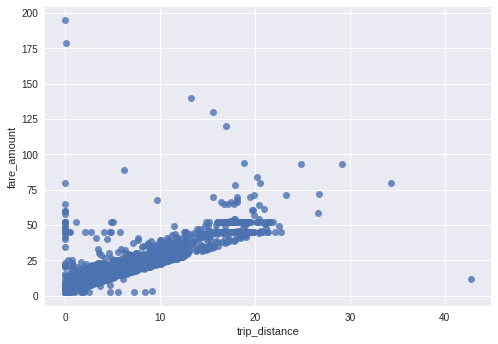

In [6]:
ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)

Hmm ... do you see something wrong with the data that needs addressing?

It appears that there is bogus data that is being coded as zero distance and some fare amounts that are definitely illegitimate. Let's remove them from our analysis. You can do this by modifying the SQL statement to keep just the trips that are longer than zero miles and with fare amounts that are at least the minimum cab fare ($2.50).

Note the extra WHERE clauses.

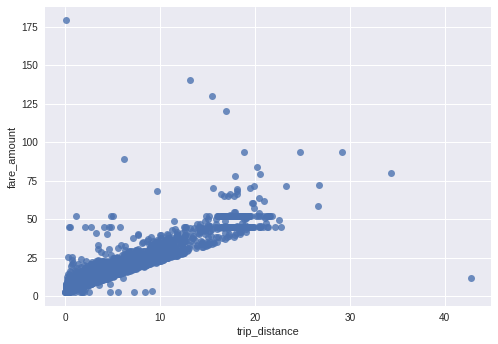

In [7]:
EVERY_N = 100000

trips = bq.query('''
  SELECT
    pickup_datetime,
    pickup_longitude, pickup_latitude, 
    dropoff_longitude, dropoff_latitude,
    passenger_count,
    trip_distance,
    tolls_amount,
    fare_amount,
    total_amount
  FROM
    `nyc-tlc.yellow.trips`
  WHERE
    MOD(ABS(FARM_FINGERPRINT(STRING(pickup_datetime))), %d) = 1
    
    #note that that trips with zero distance or 
    #costing less than $2.50 are excluded    
    AND trip_distance > 0 AND fare_amount >= 2.5    
    
''' % (EVERY_N)).to_dataframe()

ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)

What's up with the streaks at `$45` and `$50`?  Those are fixed-amount rides from JFK and La Guardia airports into anywhere in Manhattan, i.e. to be expected.

Let's examine whether the toll amount is captured in the total amount.

In [8]:
tollrides = trips[trips['tolls_amount'] > 0]
tollrides[['tolls_amount', 'fare_amount',	'total_amount']][:5]

,tolls_amount,fare_amount,total_amount
1,5.33,36.5,47.33
5,4.80,27.7,38.00
6,5.33,29.0,34.83
27,4.80,28.5,39.50
42,4.80,31.3,42.86


Looking a few samples above, it should be clear that the total amount reflects fare amount, toll and tip somewhat arbitrarily -- this is because when customers pay cash, the tip is not known.  So,  the sum of fare_amount + tolls_amount is what needs to be predicted.  Tips are discretionary and do not need to be included for fare estimation.

Let's also look at the distribution of values within the columns.

In [9]:
trips.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000
mean,-72.602192,40.002372,-72.594838,40.002052,1.650056,2.856395,0.226428,11.109446,13.217078
std,9.982373,5.474670,10.004324,5.474648,1.283577,3.322024,1.135934,9.137710,10.953156
min,-74.258183,0.000000,-74.260472,0.000000,0.000000,0.010000,0.000000,2.500000,2.500000
25%,-73.992153,40.735936,-73.991566,40.734310,1.000000,1.040000,0.000000,6.000000,7.300000
50%,-73.981851,40.753264,-73.980373,40.752956,1.000000,1.770000,0.000000,8.500000,10.000000
75%,-73.967400,40.767340,-73.964142,40.767510,2.000000,3.160000,0.000000,12.500000,14.600000
max,0.000000,41.366138,0.000000,41.366138,6.000000,42.800000,16.000000,179.000000,179.000000


Hmm ... The min, max of longitude look strange.

<h3> Quality control and other preprocessing </h3>

Some clean-up of the data is in order:
<ol>
<li>New York city longitudes are around -74 and latitudes are around 41.</li>
<li>There shouldn't be zero passengers.</li>
<li>Clean up the total_amount column to reflect only fare_amount and tolls_amount, and then remove those two columns.</li>
<li>Before the ride starts, the pickup and dropoff locations are known but not the actual trip distance (that depends on the route taken), so remove it from the ML dataset</li>
<li>Discard the timestamp</li>
</ol>

We could do this kind of preprocessing in BigQuery, similar to how we removed the zero-distance rides, but just to show you another option, let's do this in Python.  In production, we'll have to carry out the same preprocessing on the real-time input data. 

This sort of preprocessing of input data is quite common in ML, especially if the quality-control is dynamic.

In [12]:
def preprocess(trips_in):
  trips = trips_in.copy(deep=True)
  trips.fare_amount = trips.fare_amount + trips.tolls_amount
  del trips['tolls_amount']
  del trips['total_amount']
  del trips['trip_distance']
  del trips['pickup_datetime']
  qc = np.all([\
             trips['pickup_longitude'] > -78, \
             trips['pickup_longitude'] < -70, \
             trips['dropoff_longitude'] > -78, \
             trips['dropoff_longitude'] < -70, \
             trips['pickup_latitude'] > 37, \
             trips['pickup_latitude'] < 45, \
             trips['dropoff_latitude'] > 37, \
             trips['dropoff_latitude'] < 45, \
             trips['passenger_count'] > 0,
            ], axis=0)
  return trips[qc]

tripsqc = preprocess(trips)
tripsqc.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000
mean,-73.975206,40.751526,-73.974373,40.751199,1.653303,11.349003
std,0.038547,0.029187,0.039086,0.033147,1.278827,9.878630
min,-74.258183,40.452290,-74.260472,40.417750,1.000000,2.500000
25%,-73.992336,40.737600,-73.991739,40.735904,1.000000,6.000000
50%,-73.982090,40.754020,-73.980780,40.753597,1.000000,8.500000
75%,-73.968517,40.767774,-73.965851,40.767921,2.000000,12.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,179.000000


The quality control has removed about 300 rows (10700 - 10400) or about 3% of the data. This seems reasonable.

In the next lab, you will move on to creating the ML datasets.

Copyright 2019 Counter Factual .AI LLC.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.